# Convolutional Neural Network

**Notes about this specific notebook**

Uses rgb, 64x64 images with ReLU activation and Adam optimizer. No class or sample specific weights are used. Same as cnn-kaggle-v021

This notebook is set up for cross-validation, which is freq. used in research

# Changeable Parameters

_____________________________________________________________________

In [25]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'grayscale'

# Batch size
batch_size = 150000 # Set very high so it uses all the images in the directory, does not actually take 150,000 images

# Number of epochs
epoch_t = 35 # Seems to be optimal point

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# number of folds
n_folds = 10

_____________________________________________________________________

In [26]:
# To check whether the right environment has been selected
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


Import the necessary libraries

In [27]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import time

Check whether a, and which GPU is available for the computation

In [28]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
# Image size
im_si = (ih, iw)

# Convert the color channel to the corresponding number of layers
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files if computation is done locally

In [30]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/cross_validation"
    for files in os.listdir(dir):
        if "cnn" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: cgan-cnn-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/cross_validation/cgan-cnn-local-v{new_vnum:03}"
    os.makedirs(new_dir)

No matches found
New folder name: cgan-cnn-local-v001
--------------


**Data**


In [34]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"
    path_root_gen = '/kaggle/input/cganlocalv007/cgan-ckpt-local-v010-half'

if cenv == 1:
    path_root = "C:/Users/Max/Documents/thesis_data"
    path_root_gen = "C:/Users/Max/Documents/image_data/cgan-ckpt-v009-thirdsize"

Load the data. No data augmentation takes place

In [32]:
batches = ImageDataGenerator().flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs, labels = next(batches)

Found 26548 images belonging to 11 classes.


Count number of files in the CGAN folder

In [35]:
batches_gen = ImageDataGenerator().flow_from_directory(
    directory     = path_root_gen, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs_gen, labels_gen = next(batches_gen)

Found 42528 images belonging to 10 classes.


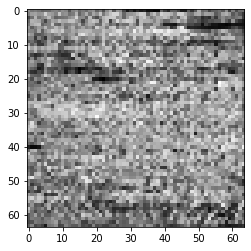

In [36]:
plt.imshow(imgs_gen[900],cmap='gray')

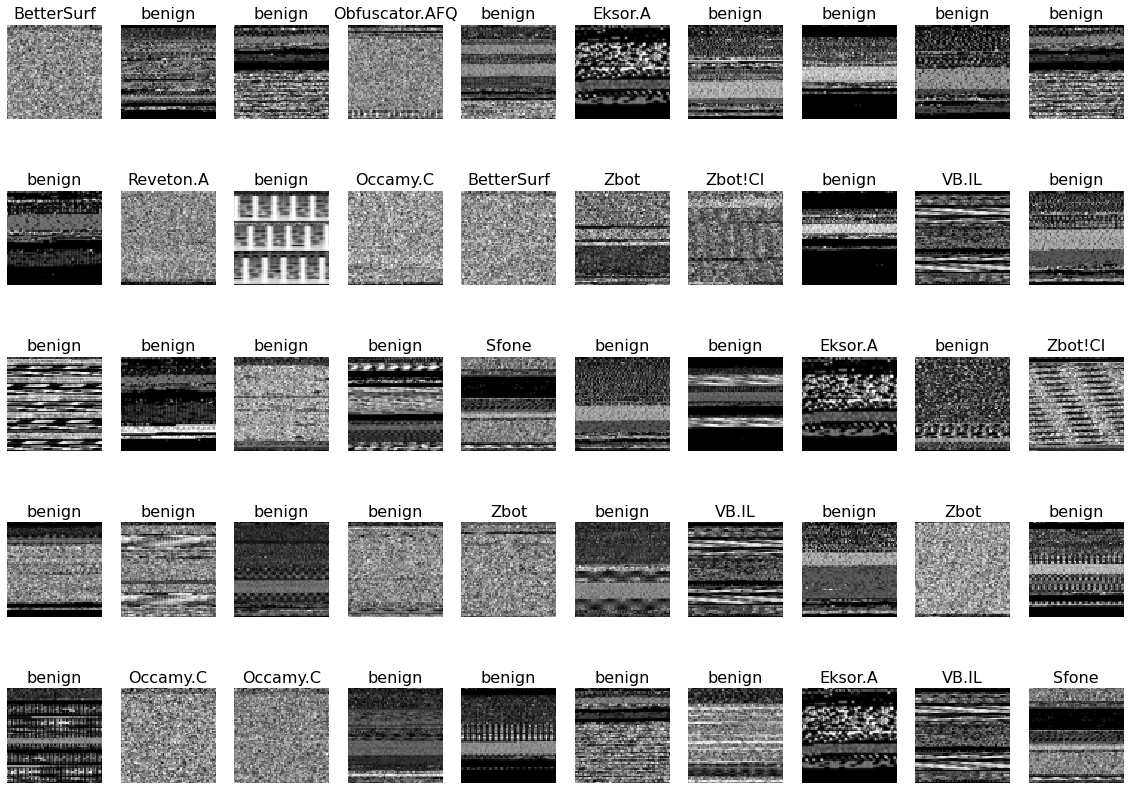

In [37]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs, titles = labels)

In [38]:
# A dictionary of all the different classes
classes = batches.class_indices.keys()
x_axis = np.arange(len(list(classes)))

Plot data distribution among all classes

Standardize images

In [39]:
imgs = imgs / 255.0
imgs_gen = imgs_gen / 255.0

Plot data distribution among train, val. and test set

# Convolutional Neural Network
We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, ReLU activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64 * 64 * 1

In [40]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold

In [41]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

We want **11** classes

In [42]:
num_classes = len(list(batches.class_indices))
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  11


Building the model

In [43]:
def malware_model():
        Malware_model = Sequential()
        Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=(ih,iw,chnum)))

        Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
        Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
        Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
        Malware_model.add(Dropout(0.25))
        Malware_model.add(Flatten())
        Malware_model.add(Dense(128, activation='relu'))
        Malware_model.add(Dropout(0.5))
        Malware_model.add(Dense(50, activation='relu'))
        Malware_model.add(Dense(num_classes, activation='softmax'))
        Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
        return Malware_model

In [44]:
def confusion_matrix(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):

        df_cm = pd.DataFrame(
            confusion_matrix, index=class_names_bin, columns=class_names_bin, 
        )
        fig = plt.figure(figsize=figsize)
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

class_names_bin= ("ransomware", "benign")

Reduce learning rate after 5 epochs of no improvement on the validition accuracy. Also save save checkpoints for the best performing model based on validation loss

In [45]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


Initialize variables to keep track of performance across folds

In [46]:
# Performance metrics
multi_acc_per_fold = []
loss_per_fold = []
multi_f1_per_fold = []
bin_acc_per_fold = []
bin_tpr_per_fold = []
bin_f1_per_fold = []
bin_mcc_per_fold = []

tp = []
fp = []
fn = []
tn = []

# Predictions
y_pred = []
y_true = []

# History
history = []

# Data distribution
train_distr = []
test_distr= []

rw_count = []
bn_count = []

In [47]:
kfold = KFold(n_splits=n_folds, shuffle=True)

Epoch 1/35
2076/2076 [==============================] - 13s 5ms/step - loss: 0.2083 - accuracy: 0.9383 - val_loss: 0.2804 - val_accuracy: 0.9205

Epoch 00001: val_loss improved from inf to 0.28044, saving model to /Users/Max/Documents/GitHub/cross_validation/cgan-cnn-local-v001\model.h5
Epoch 2/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.1039 - accuracy: 0.9676 - val_loss: 0.2255 - val_accuracy: 0.9367

Epoch 00002: val_loss improved from 0.28044 to 0.22547, saving model to /Users/Max/Documents/GitHub/cross_validation/cgan-cnn-local-v001\model.h5
Epoch 3/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0870 - accuracy: 0.9736 - val_loss: 0.1987 - val_accuracy: 0.9439

Epoch 00003: val_loss improved from 0.22547 to 0.19866, saving model to /Users/Max/Documents/GitHub/cross_validation/cgan-cnn-local-v001\model.h5
Epoch 4/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0748 - accuracy: 0.9767 - val_loss: 0.1687 - val_

2076/2076 [==============================] - 11s 5ms/step - loss: 0.1107 - accuracy: 0.9676 - val_loss: 0.2400 - val_accuracy: 0.9303

Epoch 00002: val_loss did not improve from 0.15587
Epoch 3/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0903 - accuracy: 0.9730 - val_loss: 0.1970 - val_accuracy: 0.9367

Epoch 00003: val_loss did not improve from 0.15587
Epoch 4/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0811 - accuracy: 0.9750 - val_loss: 0.1814 - val_accuracy: 0.9405

Epoch 00004: val_loss did not improve from 0.15587
Epoch 5/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0714 - accuracy: 0.9774 - val_loss: 0.1714 - val_accuracy: 0.9424

Epoch 00005: val_loss did not improve from 0.15587
Epoch 6/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0648 - accuracy: 0.9797 - val_loss: 0.1568 - val_accuracy: 0.9484

Epoch 00006: val_loss did not improve from 0.15587
Epoch 7/35
2076/2076 [====

2076/2076 [==============================] - 11s 5ms/step - loss: 0.0714 - accuracy: 0.9770 - val_loss: 0.1798 - val_accuracy: 0.9454

Epoch 00006: val_loss did not improve from 0.15097
Epoch 7/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0647 - accuracy: 0.9796 - val_loss: 0.1798 - val_accuracy: 0.9492

Epoch 00007: val_loss did not improve from 0.15097
Epoch 8/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0613 - accuracy: 0.9806 - val_loss: 0.1881 - val_accuracy: 0.9473

Epoch 00008: val_loss did not improve from 0.15097
Epoch 9/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0584 - accuracy: 0.9812 - val_loss: 0.1849 - val_accuracy: 0.9510

Epoch 00009: val_loss did not improve from 0.15097
Epoch 10/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0558 - accuracy: 0.9819 - val_loss: 0.1793 - val_accuracy: 0.9518

Epoch 00010: val_loss did not improve from 0.15097
Epoch 11/35
2076/2076 [==

2076/2076 [==============================] - 12s 6ms/step - loss: 0.0525 - accuracy: 0.9826 - val_loss: 0.1712 - val_accuracy: 0.9469

Epoch 00011: val_loss did not improve from 0.15097
Epoch 12/35
2076/2076 [==============================] - 11s 6ms/step - loss: 0.0508 - accuracy: 0.9835 - val_loss: 0.1770 - val_accuracy: 0.9454

Epoch 00012: val_loss did not improve from 0.15097
Epoch 13/35
2076/2076 [==============================] - 11s 6ms/step - loss: 0.0483 - accuracy: 0.9846 - val_loss: 0.1817 - val_accuracy: 0.9446

Epoch 00013: val_loss did not improve from 0.15097
Epoch 14/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0474 - accuracy: 0.9842 - val_loss: 0.1821 - val_accuracy: 0.9443

Epoch 00014: val_loss did not improve from 0.15097
Epoch 15/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0452 - accuracy: 0.9851 - val_loss: 0.1898 - val_accuracy: 0.9476

Epoch 00015: val_loss did not improve from 0.15097
Epoch 16/35
2076/2076 

2076/2076 [==============================] - 11s 6ms/step - loss: 0.0408 - accuracy: 0.9863 - val_loss: 0.1855 - val_accuracy: 0.9461

Epoch 00016: val_loss did not improve from 0.15097
Epoch 17/35
2076/2076 [==============================] - 11s 6ms/step - loss: 0.0404 - accuracy: 0.9872 - val_loss: 0.1900 - val_accuracy: 0.9469

Epoch 00017: val_loss did not improve from 0.15097
Epoch 18/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0380 - accuracy: 0.9876 - val_loss: 0.2044 - val_accuracy: 0.9446

Epoch 00018: val_loss did not improve from 0.15097
Epoch 19/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0386 - accuracy: 0.9873 - val_loss: 0.1923 - val_accuracy: 0.9469

Epoch 00019: val_loss did not improve from 0.15097
Epoch 20/35
2076/2076 [==============================] - 12s 6ms/step - loss: 0.0370 - accuracy: 0.9878 - val_loss: 0.2072 - val_accuracy: 0.9465

Epoch 00020: val_loss did not improve from 0.15097
Epoch 21/35
2076/2076 

2076/2076 [==============================] - 11s 5ms/step - loss: 0.0346 - accuracy: 0.9888 - val_loss: 0.1728 - val_accuracy: 0.9650

Epoch 00020: val_loss did not improve from 0.13228
Epoch 21/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0342 - accuracy: 0.9887 - val_loss: 0.1460 - val_accuracy: 0.9635

Epoch 00021: val_loss did not improve from 0.13228
Epoch 22/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0326 - accuracy: 0.9893 - val_loss: 0.2196 - val_accuracy: 0.9567

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00022: val_loss did not improve from 0.13228
Epoch 23/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0278 - accuracy: 0.9905 - val_loss: 0.1471 - val_accuracy: 0.9661

Epoch 00023: val_loss did not improve from 0.13228
Epoch 24/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0257 - accuracy: 0.9916 - val_loss: 0.1492 - val_accuracy: 

2076/2076 [==============================] - 11s 6ms/step - loss: 0.0263 - accuracy: 0.9909 - val_loss: 0.1643 - val_accuracy: 0.9616

Epoch 00025: val_loss did not improve from 0.13228
Epoch 26/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0231 - accuracy: 0.9922 - val_loss: 0.1707 - val_accuracy: 0.9612

Epoch 00026: val_loss did not improve from 0.13228
Epoch 27/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0247 - accuracy: 0.9919 - val_loss: 0.1702 - val_accuracy: 0.9612

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00027: val_loss did not improve from 0.13228
Epoch 28/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0221 - accuracy: 0.9925 - val_loss: 0.1680 - val_accuracy: 0.9620

Epoch 00028: val_loss did not improve from 0.13228
Epoch 29/35
2076/2076 [==============================] - 11s 5ms/step - loss: 0.0202 - accuracy: 0.9929 - val_loss: 0.1793 - val_accuracy: 

2076/2076 [==============================] - 12s 6ms/step - loss: 0.0201 - accuracy: 0.9932 - val_loss: 0.2491 - val_accuracy: 0.9522

Epoch 00030: val_loss did not improve from 0.13228
Epoch 31/35
2076/2076 [==============================] - 11s 6ms/step - loss: 0.0199 - accuracy: 0.9935 - val_loss: 0.2398 - val_accuracy: 0.9537

Epoch 00031: val_loss did not improve from 0.13228
Epoch 32/35
2076/2076 [==============================] - 12s 6ms/step - loss: 0.0186 - accuracy: 0.9935 - val_loss: 0.2611 - val_accuracy: 0.9533

Epoch 00032: val_loss did not improve from 0.13228
Epoch 33/35
2076/2076 [==============================] - 12s 6ms/step - loss: 0.0179 - accuracy: 0.9940 - val_loss: 0.2558 - val_accuracy: 0.9537

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00033: val_loss did not improve from 0.13228
Epoch 34/35
2076/2076 [==============================] - 12s 6ms/step - loss: 0.0185 - accuracy: 0.9936 - val_loss: 0.2568 - val_accuracy: 

2076/2076 [==============================] - 12s 6ms/step - loss: 0.0185 - accuracy: 0.9938 - val_loss: 0.2087 - val_accuracy: 0.9533

Epoch 00034: val_loss did not improve from 0.13228
Epoch 35/35
2076/2076 [==============================] - 12s 6ms/step - loss: 0.0180 - accuracy: 0.9939 - val_loss: 0.2132 - val_accuracy: 0.9518

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00035: val_loss did not improve from 0.13228
Score for fold 9: loss of 0.21320413053035736; accuracy of 95.17709016799927%
Epoch 1/35
2076/2076 [==============================] - 12s 6ms/step - loss: 0.2170 - accuracy: 0.9357 - val_loss: 0.2940 - val_accuracy: 0.9133

Epoch 00001: val_loss did not improve from 0.13228
Epoch 2/35
2076/2076 [==============================] - 12s 6ms/step - loss: 0.1121 - accuracy: 0.9671 - val_loss: 0.2448 - val_accuracy: 0.9288

Epoch 00002: val_loss did not improve from 0.13228
Epoch 3/35
2076/2076 [==============================] - 12s 6ms/step - loss: 0

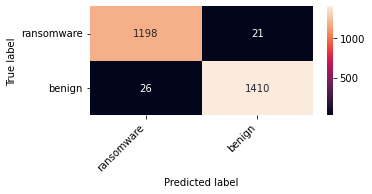

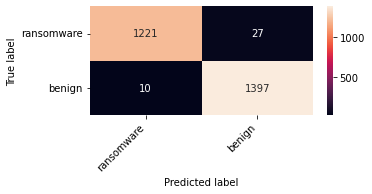

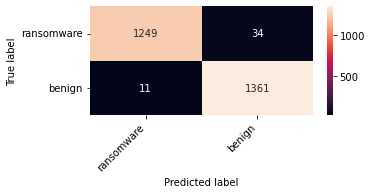

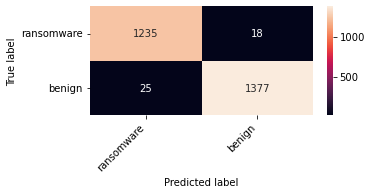

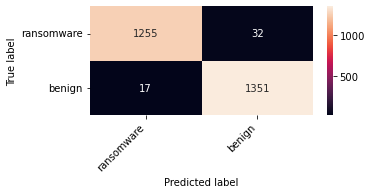

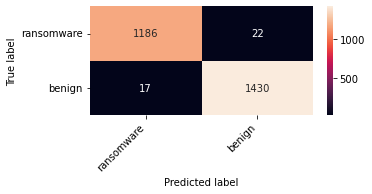

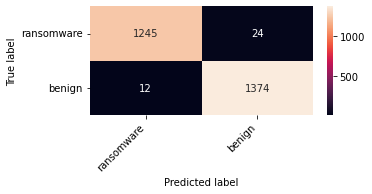

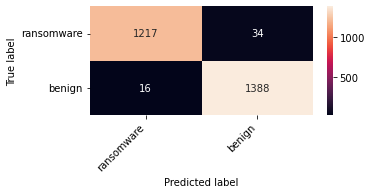

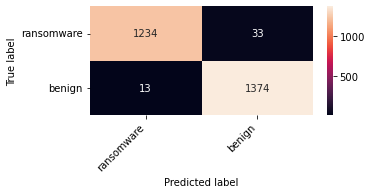

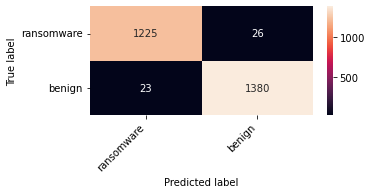

In [48]:
fold_no = 1

for train, test in kfold.split(imgs,labels):
    
    # Compile the CNN
    Malware_model = malware_model()
    
    # Add generated images to training data   
    train_images = np.concatenate((imgs[train], imgs_gen), axis = 0)
    train_labels = to_categorical(np.concatenate((np.argmax(labels[train], axis = 1), np.argmax(labels_gen, axis = 1)), axis = 0))

    # Run the CNN
    history.append(
        Malware_model.fit(
        train_images, 
        train_labels, 
        validation_data=(imgs[test], labels[test]), 
        epochs=epoch_t,
        callbacks = [anne, checkpoint]) # The actual computation of the CNN
    )
    
    # Generate generalization metrics
    scores = Malware_model.evaluate(imgs[test], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {Malware_model.metrics_names[0]} of {scores[0]}; {Malware_model.metrics_names[1]} of {scores[1]*100}%')
    multi_acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    # Create two 1D-arrays: one with the prediction per image of the model and one with the true labels
    y_pred = np.append(y_pred, np.argmax(Malware_model.predict(imgs[test]), axis=-1))
    y_true = np.append(y_true, np.argmax(labels[test], axis=1))
    
    y_pred2 = np.argmax(Malware_model.predict(imgs[test]), axis=-1)
    y_true2 = np.argmax(labels[test], axis=1)
    
    # Binary
    y_predbin = [] 
    y_truebin = []
    for count, value in enumerate(y_true2):
        if y_true2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_truebin.append(0)
        else: y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

        if y_pred2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_predbin.append(0)
        else: y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
        continue
        
    rw_count.append(len(y_truebin) - np.sum(y_truebin))
    bn_count.append(np.sum(y_truebin))
    
    # Binary confusion Matrix
    c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)
    
    confusion_matrix(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)
    
    tp.append(c_matrix_bin[0,0])
    fp.append(c_matrix_bin[0,1])
    fn.append(c_matrix_bin[1,0])
    tn.append(c_matrix_bin[1,1])
    
    multi_f1_per_fold.append(f1_score(y_true2, y_pred2, average='macro'))
    bin_tpr_per_fold.append(c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1])) #True Positive Rate
    bin_acc_per_fold.append(accuracy_score(y_truebin, y_predbin)) # Accuracy
    bin_f1_per_fold.append(f1_score(y_truebin, y_predbin, labels=0)) # F1 Score
    bin_mcc_per_fold.append(matthews_corrcoef(y_truebin, y_predbin))  # Matthews Correlation Coefficient
    
    train_distr.append((sum(train_labels)/train_labels.shape[0])*100)
    test_distr.append((sum(labels[test])/labels[test].shape[0])*100)
    

Cross validation run overview

In [49]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(multi_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {multi_acc_per_fold[i]*100}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(multi_acc_per_fold)*100}% (+- {np.std(multi_acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.20893380045890808 - Accuracy: 95.70621252059937%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.21753382682800293 - Accuracy: 95.6685483455658%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.23867690563201904 - Accuracy: 95.25423645973206%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.21727588772773743 - Accuracy: 95.17890810966492%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.24509896337985992 - Accuracy: 94.91525292396545%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.16986314952373505 - Accuracy: 96.49717807769775%
-------------------------------------------------------------------

# Evaluating performance

Create data distribution graph (I will use around 20% of cases for benign for and the remaining 80% equally distributed across the 10 ransomware families)

In [50]:
np.array(train_distr)

array([[ 9.10856506,  9.31633068,  7.75056082,  7.77013294,  7.60452267,
         8.25642493,  7.85594917,  8.29858027,  7.60602821,  7.49913431,
        18.93377095],
       [ 9.13566493,  9.30428629,  7.73249424,  7.73399979,  7.62108369,
         8.28804143,  7.84089369,  8.30309691,  7.58495054,  7.47805664,
        18.97743184],
       [ 9.05135424,  9.35848602,  7.76862739,  7.74303308,  7.58495054,
         8.25491938,  7.84842143,  8.2744915 ,  7.59247828,  7.49311212,
        19.03012601],
       [ 9.10103732,  9.33439725,  7.74303308,  7.75658301,  7.58796164,
         8.28352479,  7.85594917,  8.29858027,  7.56838952,  7.48558438,
        18.98495958],
       [ 9.1537315 ,  9.3389139 ,  7.74754972,  7.70087773,  7.60753376,
         8.25341383,  7.82433267,  8.28051369,  7.5774228 ,  7.47956219,
        19.03614821],
       [ 9.09953177,  9.37956369,  7.73851643,  7.77766068,  7.60602821,
         8.25943602,  7.84541034,  8.30460246,  7.58495054,  7.48708993,
        18.917

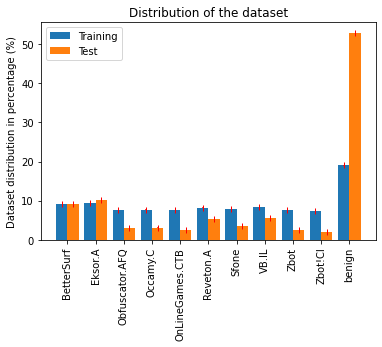

In [51]:
perc_train = np.mean(train_distr, axis = 0)
perc_test =  np.mean(test_distr, axis = 0)

plt.bar(x_axis - 0.2, perc_train, 0.4, label = 'Training')
plt.errorbar(x_axis - 0.2, perc_train, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize = 0)

plt.bar(x_axis + 0.2, perc_test,0.4, label = 'Test')
plt.errorbar(x_axis + 0.2, perc_test, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize=0.0)


plt.title('Distribution of the dataset')
plt.ylabel('Dataset distribution in percentage (%)')
plt.xticks(x_axis, list(classes), rotation='vertical')
plt.legend()

if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight', dpi = 150)

In [52]:
t = PrettyTable(['Metric', 'Performance', 'St.Deviation'])
t.add_row(['M-Class', "", ""])
t.add_row(['Acc    ', round(np.mean(multi_acc_per_fold),4), round(np.std(multi_acc_per_fold),4)])
t.add_row(['Loss   ', round(np.mean(loss_per_fold),4), round(np.std(loss_per_fold),4)])
t.add_row(['Macro F1', round(np.mean(multi_f1_per_fold), 4), round(np.std(multi_f1_per_fold),4)])
t.border = True
t.add_row(['', '', ''])
t.add_row(['B-Class', "", ""])
t.add_row(['TPR    ', round(np.mean(bin_tpr_per_fold),4), round(np.std(bin_tpr_per_fold),4)])
t.add_row(['Acc    ', round(np.mean(bin_acc_per_fold),4), round(np.std(bin_acc_per_fold),4)])
t.add_row(['F1     ', round(np.mean(bin_f1_per_fold),4), round(np.std(bin_f1_per_fold),4)])
t.add_row(['MCC    ', round(np.mean(bin_mcc_per_fold),4), round(np.std(bin_mcc_per_fold),4)])
t.header = True
t.set_style(MSWORD_FRIENDLY)
t.align = "l"
t.title = "Performance of CGAN - CNN"
print(t)

+---------------------------------------+
|       Performance of CGAN - CNN       |
| Metric   | Performance | St.Deviation |
| M-Class  |             |              |
| Acc      | 0.9549      | 0.0051       |
| Loss     | 0.2203      | 0.0288       |
| Macro F1 | 0.8831      | 0.0105       |
|          |             |              |
| B-Class  |             |              |
| TPR      | 0.9784      | 0.0042       |
| Acc      | 0.9834      | 0.0018       |
| F1       | 0.9843      | 0.0018       |
| MCC      | 0.9667      | 0.0037       |


In [53]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

Evaluate the model based on the test set

Save a table with the performance on the test set

**Evaluating overfitting and other model performance measures**

In [54]:
linecolours = ['gray', 'orange', 'blue', 'green','silver', 'cyan', 'red', 'purple', 'lightgreen', 'black', 'brown']

In [55]:
def eval_metric(model, history, metric_name, ymin, ymax):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    for i in range(n_folds-1):  
        metric = history[i].history[metric_name]
        val_metric = history[i].history['val_' + metric_name]
        e = range(1, epoch_t + 1)
        plt.plot(e, metric, marker = 'o', linestyle = 'none', color = linecolours[i])
        plt.plot(e, val_metric, color = linecolours[i])
        
    metric = history[n_folds-1].history[metric_name]
    val_metric = history[n_folds-1].history['val_' + metric_name]
    e = range(1, epoch_t + 1)
    plt.plot(e, metric, marker = 'o', linestyle = 'none', label = 'Training', color = linecolours[n_folds-1])
    plt.plot(e, val_metric, label = 'Validation', color = linecolours[n_folds-1])
    
    plt.ylim(ymin, ymax)
    
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for CGAN-CNN across folds')
    plt.legend()
    if cenv == 0:
        plt.savefig(f"cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)

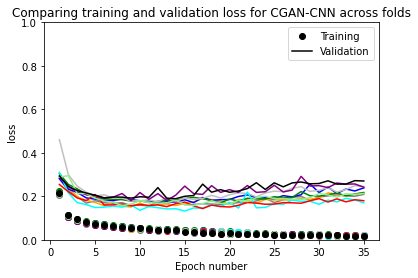

In [56]:
eval_metric(Malware_model, history, 'loss', 0,1)

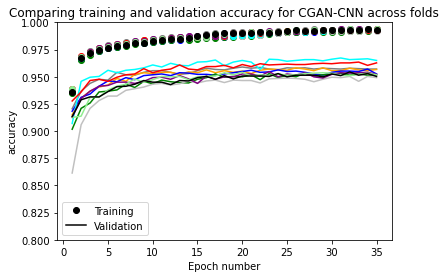

In [57]:
eval_metric(Malware_model, history, 'accuracy', 0.8,1)

# Confusion Matrix
Analysing the results

# Binary classification
y_predbin and y_testbin are the binary classification arrays. 0 = ransomware and 1 = benign

Plot the distribution of dataset as ransomware - benign

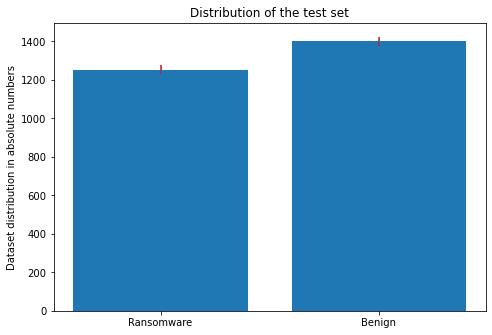

In [58]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [np.mean(rw_count), np.mean(bn_count)]
plt.title('Distribution of the test set')
plt.ylabel('Dataset distribution in absolute numbers')
ax.bar(x_lab, y_lab)
ax.errorbar(x_lab, y_lab, yerr = [np.std(rw_count), np.std(bn_count)], fmt = '|', ecolor='red')
if cenv == 0:
    plt.savefig("bin_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight', dpi = 150)

Plot binary confusion matrix

In [59]:
all_y_predbin = [] 
all_y_truebin = []
for count, value in enumerate(y_true):
    if y_true[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_truebin.append(0)
    else: all_y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

    if y_pred[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_predbin.append(0)
    else: all_y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
    continue

In [60]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, name, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f"{(name.capitalize())} Confusion Matrix - CGAN-CNN")
    if cenv == 0:
        plt.savefig(f"{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)

In [61]:
c_matrix_bin = metrics.confusion_matrix(all_y_truebin, all_y_predbin)

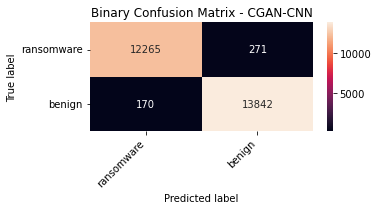

In [62]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, 'binary', figsize = (5,2), fontsize=10)

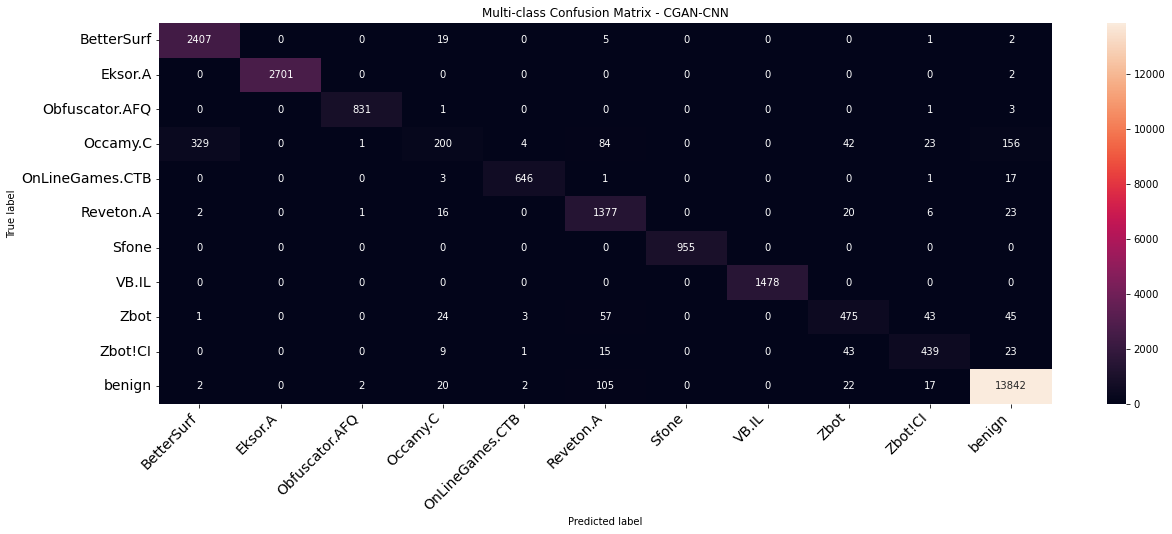

In [63]:
c_matrix = metrics.confusion_matrix(y_true, y_pred)
class_names= batches.class_indices.keys()
confusion_matrix_bin(c_matrix, class_names, 'multi-class', figsize = (20,7), fontsize=14)